## Evapotranspiration and balance calculations at the atmospheric boundary

This excercise looks into hydropedological processes at the interface of soils with the atmosphere. We will use observed lysimeter data as a reference for water balance and evapotranspiration (ET) calculations.

Let's go.

(cc) conrad.jackisch@tbt.tu-freiberg.de, May 04, 2022

In [2]:
%pylab inline
import pandas as pd
import seaborn as sns
import plotly.express as px

import plotly.io as pio
pio.renderers.default='iframe' #for windows use 'notebook' instead
from plotly.subplots import make_subplots
import plotly.graph_objects as go

sns.set_style('whitegrid', {'grid.linestyle': u'--'})
matplotlib.rc('pdf', fonttype=42)

Populating the interactive namespace from numpy and matplotlib


### Lysimeter

You get data from a lysimeter station. The files `lysimeter.csv` and `lysimeter_climate.csv` hold the water balance for the lysimeter and the reference meteorological observations. 

 1. Please calculate the observed actual ET.
 2. You know that ET correlates with vapour pressure deficit and radiation. Analyse both correlations.
 3. You know that there are many (more or less) empirical ET models. Please calculate different ET estimates and compare them to the observed time series


In [47]:
# Read lysimeter data
lysi = pd.read_csv('lysimeter.csv', sep=';', index_col=0)
lysi.index = pd.to_datetime(lysi.index, format='%d.%m.%Y')

# This is in the lysimeter data:
# date (dd.mm.yyyy)
# Precipitation;Seepage;StorageChange;Snowheight [mm]

# unfortunately there is an erroneous value in the time series with a dublicated date on Aug 24, 1993
# we have to remove it
lysi = lysi.loc[~lysi.index.duplicated(), :]

lysi_cli = pd.read_csv('lysimeter_climate.csv', sep=';', index_col=0)
lysi_cli.index = pd.to_datetime(lysi_cli.index, format='%d.%m.%Y')

# This is in the climate data:
# date (dd.mm.yyyy)	
# Temp	mean temperature [°C]
# Tmax	max temperature [°C]
# Tmin	min temperature [°C]
# T14	temperature	at 14:00 o'clock [°C]
# RH	air humidity [%] in 2m height
# RH14	air humidity [%] at 14 o'clock
# Rad global radiation [J/cm²]
# Prec	precipitation height [mm]
# u2	wind speed [m/s] in 2 m height
# u10	wind speed [m/s] in 10 m height


In [48]:
# Use the water balance to calculate ET
lysi['actET'] = lysi.Precipitation - lysi.Seepage - lysi.StorageChange

# clean obvious erroneous data by overwriting with nan
lysi.loc[lysi.actET>11.] = np.nan
lysi.loc[lysi.actET<-0.3] = np.nan

# mask times with snow to very low ET
lysi.loc[lysi.Snowheight>0.] = 0.1

fig = px.line(lysi.actET)
fig.update_layout({'template': 'none','title': 'actual ET @ lysimeter'})

In [108]:
# vapour pressure deficit
# use the Magnus equation to calculate the saturation vapour pressure reference
# and refer it to the actual vapour pressure with the given RH and temperature

# Saturated vapour pressure based on Tmean
lysi_cli['vs_Tmean'] = 0.61078 * np.exp(17.1 * lysi_cli['Temp'] / (lysi_cli['Temp'] + 235.)) 

# Saturated vapour pressure based on Tmin/Tmax
vs_Tmax = 0.61078 * np.exp(17.1 * lysi_cli['Tmax'] / (lysi_cli['Tmax'] + 235.))  
vs_Tmin = 0.61078 * np.exp(17.1 * lysi_cli['Tmin'] / (lysi_cli['Tmin'] + 235.)) 
lysi_cli['vas'] = (vs_Tmax + vs_Tmin) / 2.

In [109]:
#linear regression fitting helper function
#you can simply use and modify it as you like

def linfit(df,c1='actET',c2='vas',zeroi=True,pltx=True,applymod=False):
    '''This is a linear regression wrapper function taking a pandas DataFrame and performing
       a linear regression with statsmodels on two columns of the data.
       df :: DataFrame with at least two columns
       c1 :: column one to be used as x
       c2 :: column two used as y
       
       Returns a linerar regression fit model. Pls. see the docs of statsmodels for details.
       
       Example: res = linfit(df,c1='actET',c2='vas')
       Get regression summary: res.summary()
    '''
    import statsmodels.formula.api as smf 
    from statsmodels.sandbox.regression.predstd import wls_prediction_std
    #import statsmodels.api as sm
    from scipy import stats
    df = df.sort_values(by=c2)[[c1,c2]].reset_index()
    if zeroi: #zero intercept
        result = smf.ols(formula=c1+' ~ '+c2+' - 1', data=df).fit()
    else:
        result = smf.ols(formula=c1+' ~ '+c2, data=df).fit()
    y_hat = result.predict(df[c2])
    y_err = df[c1].values - y_hat
    s_err = np.sum(np.power(y_err, 2))
    mean_x = df[c2].mean()
    
    #confidence intervals
    n = len(df)
    x_pred = np.linspace(df[c2].min(), df[c2].max(), 50)
    y_pred = result.predict(pd.Series(x_pred,name=c2))
    dof = n - result.df_model - 1
    t = stats.t.ppf(1-0.05, df=dof)
    conf = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((x_pred-mean_x),2) / ((np.sum(np.power(x_pred,2))) - n*(np.power(mean_x,2))))))
    upper = y_pred + abs(conf)
    lower = y_pred - abs(conf)
    
    #prediction interval
    #sdev, lower2, upper2 = wls_prediction_std(result, exog=sm.add_constant(x_pred), alpha=0.05)
    
    if pltx & applymod:
        ax = plt.subplot(1,1,1)
        ax.scatter(df[c2], df[c1]/result.params[0], alpha=0.5)
        ax.plot(x_pred, y_pred/result.params[0], '-', linewidth=2)
        ax.fill_between(x_pred, lower/result.params[0], upper/result.params[0], color='#888888', alpha=0.4)
        #ax.fill_between(x_pred, lower2, uppe2, color='#888888', alpha=0.1)
        
        return result
    elif pltx & ~applymod:
        ax = plt.subplot(1,1,1)
        ax.scatter(df[c2], df[c1], alpha=0.5)
        ax.plot(x_pred, y_pred, '-', linewidth=2)
        ax.fill_between(x_pred, lower, upper, color='#888888', alpha=0.4)
        ax.set_xlabel(c1)
        ax.set_ylabel(c2)
        ax.set_title('R² = '+str(np.round(result.rsquared,2))+'  p = '+str(np.round(result.pvalues[0],3)))
        return result
    else:
        return result,x_pred,y_pred,lower,upper,conf

/Users/cojack/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning:

invalid value encountered in sqrt



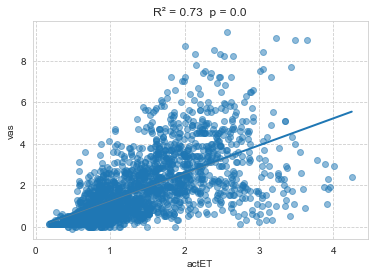

In [110]:
#stitch together all the needed columns for comparison
#using pd.concat will take care about the index alignment
#drop nans if there are any
df = pd.concat([lysi.actET,lysi_cli.vas,lysi_cli.vs_Tmean,lysi_cli.Rad],axis=1).dropna()
res = linfit(df,c1='actET',c2='vas')


In [111]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  actET   R-squared (uncentered):                   0.727
Model:                            OLS   Adj. R-squared (uncentered):              0.727
Method:                 Least Squares   F-statistic:                              5417.
Date:                Wed, 04 May 2022   Prob (F-statistic):                        0.00
Time:                        07:46:09   Log-Likelihood:                         -3342.2
No. Observations:                2033   AIC:                                      6686.
Df Residuals:                    2032   BIC:                                      6692.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
vas            1.3036      0.018     73.598      0.000       1.269       1.338
==============================================================================
Omnibus:                      370.751   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              938.223
Skew:                           0.986   Prob(JB):                    1.85e-204
Kurtosis:                       5.680   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ET calculation
There are a couple of ET functions coded in [*pyeto*](https://pyeto.readthedocs.io/en/latest/overview.html). You might need to install them with `!pip install pyeto`.

In [84]:
import pyeto as pt
lysi_cli['EToPM'] = pt.fao56_penman_monteith(lysi_cli.Rad.values*0.01,lysi_cli.Temp.values+273.15,lysi_cli.u2.values,pt.svp_from_t(lysi_cli.Temp.values),lysi_cli.vas*0.1,pt.delta_svp(lysi_cli.Temp.values),pt.psy_const(100.))
lysi_cli['EToHG'] = pt.hargreaves(lysi_cli.Tmin.values,lysi_cli.Tmax.values,lysi_cli.Temp.values,pt.et_rad(52. * np.pi/180.,pt.sol_dec(lysi_cli.index.dayofyear.values),pt.sunset_hour_angle(52. * np.pi/180.,pt.sol_dec(lysi_cli.index.dayofyear.values)),pt.inv_rel_dist_earth_sun(lysi_cli.index.dayofyear.values)))

In [122]:
#calculate further ET models
import dwd as dwd
EToSJ, EToPM2, EToPT = dwd.ET_SzilagyiJozsa(lysi_cli)
dummy = pd.concat([EToSJ, EToPM2, EToPT],axis=1).astype(np.float)
dummy.columns = ['EToSJ', 'EToPM2', 'EToPT']

lysi_ET = pd.concat([lysi_cli[['EToPM','EToHG']],dummy,lysi.actET],axis=1).dropna()

In [123]:
lysi_ET.head()

,EToPM,EToHG,EToSJ,EToPM2,EToPT,actET
date,,,,,,
1992-06-01,5.520748,5.350392,4.706004,4.150259,4.428131,4.6
1992-06-02,6.989699,5.716374,5.862282,4.994180,5.428231,5.5
1992-06-03,4.351732,4.854608,4.069128,3.397625,3.733377,2.9
1992-06-04,4.754582,5.205013,4.530525,3.506385,4.018455,5.6
1992-06-05,6.709165,6.304331,5.613334,4.864739,5.239037,7.2


In [126]:
fig = px.line(lysi_ET)
fig.update_layout({'template': 'none','title': 'ET @ lysimeter','yaxis_title': 'ET (mm/day)'})

/Users/cojack/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning:

invalid value encountered in sqrt



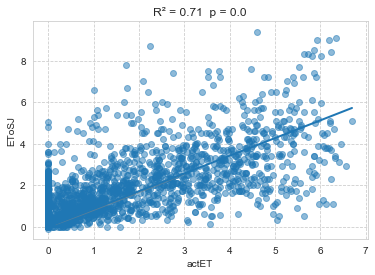

In [107]:
linfit(lysi_ET,'actET','EToSJ')

'/Users/cojack/miniconda3/lib/python3.7/site-packages/pyeto/__init__.py'